In [264]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [265]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
holes
1        1
dtype: int64
Filling holes up to length 3
Any remaining holes after interpolation? False


In [266]:
df = df1[['consumption']]

df

,consumption
2017-05-01 00:00:00+00:00,3325.431995
2017-05-01 01:00:00+00:00,3344.690998
2017-05-01 02:00:00+00:00,3398.359002
2017-05-01 03:00:00+00:00,3430.220001
2017-05-01 04:00:00+00:00,3606.750000
...,...
2023-01-21 19:00:00+00:00,5947.502808
2023-01-21 20:00:00+00:00,5868.196111
2023-01-21 21:00:00+00:00,5742.156776
2023-01-21 22:00:00+00:00,5653.673398


In [267]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1, shuffle=False)

In [268]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [269]:
df_train

,consumption
2017-05-01 00:00:00+00:00,-0.520736
2017-05-01 01:00:00+00:00,-0.506271
2017-05-01 02:00:00+00:00,-0.465960
2017-05-01 03:00:00+00:00,-0.442029
2017-05-01 04:00:00+00:00,-0.309436
...,...
2021-12-20 07:00:00+00:00,1.151071
2021-12-20 08:00:00+00:00,1.168536
2021-12-20 09:00:00+00:00,1.153706
2021-12-20 10:00:00+00:00,1.116430


In [270]:
def generate_sequences(df, tw, pw):    
    data = dict()
    L = len(df)
    for i in range(L-tw):
        sequence = df[i:i+tw].values 
        target = df[i+tw:i+tw+pw].values

        data[i] = {'sequence': sequence, 'target': target}

    return data

In [271]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
    

In [272]:
tw = 100
pw = 1

train_dataset = SequenceDataset(generate_sequences(df_train, tw, pw))
val_dataset = SequenceDataset(generate_sequences(df_validation, tw, pw))
test_dataset = SequenceDataset(generate_sequences(df_test, tw, pw))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [273]:
train_loader.dataset.data

{0: {'sequence': array([[-0.52073629],
         [-0.50627068],
         [-0.46596014],
         [-0.44202905],
         [-0.30943574],
         [-0.20944283],
         [-0.1246839 ],
         [-0.03768067],
         [-0.00523651],
         [-0.06212853],
         [-0.1550182 ],
         [-0.24585059],
         [-0.32667145],
         [-0.39030918],
         [-0.42842722],
         [-0.45269406],
         [-0.46967438],
         [-0.4601413 ],
         [-0.4076921 ],
         [-0.30026695],
         [-0.31013578],
         [-0.41565085],
         [-0.52495301],
         [-0.59799538],
         [-0.60741729],
         [-0.57604121],
         [-0.51535459],
         [-0.40059111],
         [-0.0126755 ],
         [ 0.31334722],
         [ 0.30271978],
         [ 0.15585013],
         [ 0.05002861],
         [-0.04750743],
         [-0.09035446],
         [-0.14616488],
         [-0.2103727 ],
         [-0.27368219],
         [-0.29656849],
         [-0.34573084],
         [-0.40497534],
 

In [274]:
class LSTMModel(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm=1, n_deep=2):
        super().__init__()

        self.n_lstm = n_lstm
        self.n_hid = n_hidden

        self.lstm = nn.LSTM(n_features, n_hidden, num_layers=n_lstm, batch_first=True)

        self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_outputs)



    def forward(self, x):

        # Initialize hidden state and cell state
        hidden_state = torch.zeros(self.n_lstm, x.shape[0], self.n_hid)
        cell_state = torch.zeros(self.n_lstm, x.shape[0], self.n_hid)

        self.hidden = (hidden_state, cell_state)

        # Forward pass
        x, h = self.lstm(x, self.hidden)
        x = x.contiguous().view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [275]:
# Init model
model = LSTMModel(n_features=1, n_hidden=64, n_outputs=1, sequence_len=100)
model

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [276]:
def validation(val_loader, criterion, model):
    model.eval()
    val_losses = []
    for x, y in val_loader:
        y = y.squeeze()
        preds = model(x).squeeze()
        val_loss = criterion(preds, y)
        val_losses.append(val_loss)
    print(f"Validation Loss: {sum(val_losses) / len(val_losses)}")

In [277]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

for epoch in range(5):
    model.train()

    losses = []

    for x, y in train_loader:

        y = y.squeeze()
        
        optimizer.zero_grad()

        preds = model(x).squeeze()

        loss = criterion(preds, y)
        losses.append(loss.item())

        loss.backward()

        optimizer.step()
    
    print(f"Epoch {epoch} train loss: {sum(losses) / len(losses)}")
    validation(val_loader, criterion, model)

Epoch 0 train loss: 0.025229354094068544
Validation Loss: 0.007796590682119131
Epoch 1 train loss: 0.005589631476421894
Validation Loss: 0.003932798281311989
Epoch 2 train loss: 0.0026090640945715836
Validation Loss: 0.0017537970561534166
Epoch 3 train loss: 0.0016311836225558042
Validation Loss: 0.001275799237191677
Epoch 4 train loss: 0.0013332735206966744
Validation Loss: 0.0015655721072107553


In [290]:
def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).numpy()
    actuals = torch.cat(actuals).numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

In [291]:
predictions, actuals, test_loss = make_preds(model, test_loader, criterion)

In [292]:
print(predictions * train_std['consumption'] + train_mean['consumption'])
print(actuals * train_std['consumption'] + train_mean['consumption'])

[2066.0854 5803.138  2732.8486 ... 5234.59   2833.0303 2397.9387]
[2024.1061 5875.8584 2709.3438 ... 5216.744  2757.2559 2379.8967]


In [293]:
print(f"Final test loss: {test_loss}")

Final test loss: 0.0013462797505781054


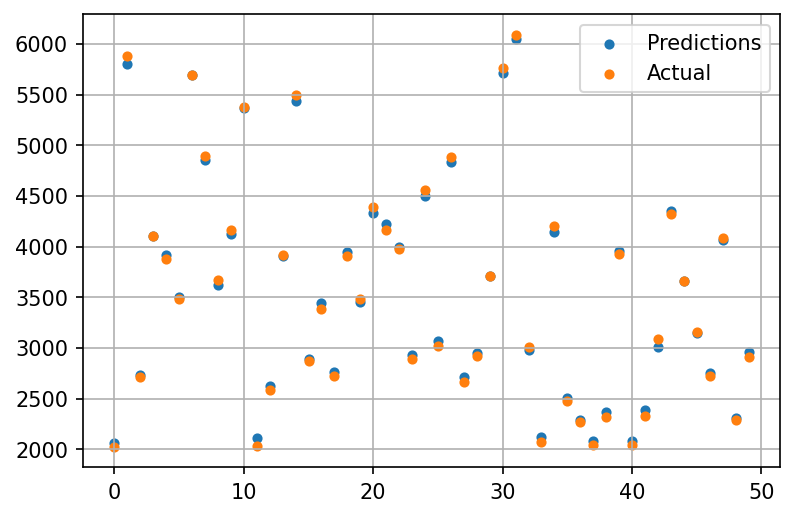

In [303]:
n = 50

pred = predictions[0:n] * train_std['consumption'] + train_mean['consumption']
act = actuals[0:n] * train_std['consumption'] + train_mean['consumption']

x = pred.shape[0]
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.scatter(range(x), pred, label="Predictions", s=15)
plt.scatter(range(x), act, label="Actual", s=15)
plt.legend()
plt.show()

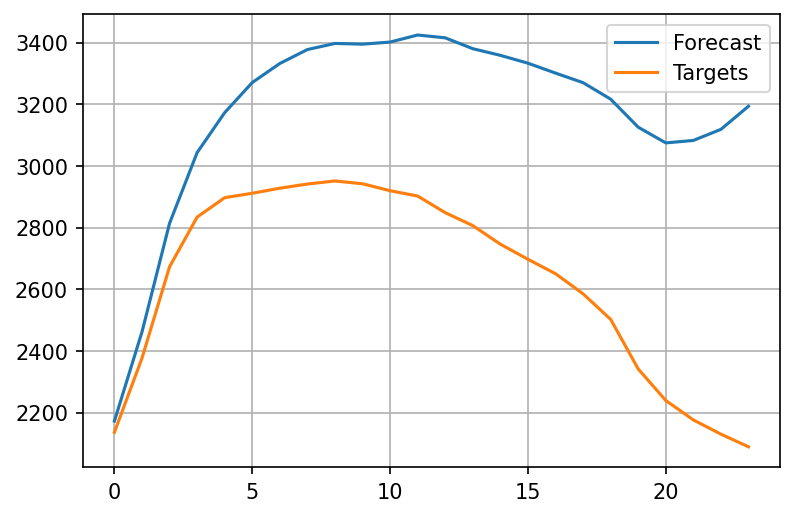

In [356]:
# Forecasting
start_point = 100
tw = 100
fw = 24

history = list(df_test['consumption'])[start_point: start_point+tw+fw]
targets = history[tw:tw+fw]

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = np.array(history[i:tw+i]).reshape(-1, 1)

    x = torch.Tensor(x).unsqueeze(0)
    pred = model(x)

    predictions.append(pred.item())

    history[-fw+i] = pred.item()

predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()
